In [2]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time

tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
rescale = Rescaling(scale=1.0/255,name='rescale')
preprocess = lambda x,y: ((x-127.5)/127.5 ,y)

In [5]:
no_of_class = 102
IMG_SIZE = (120,120)

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,labels=[1 for _ in range(6552)],shuffle=False)
test = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/valid/',image_size=IMG_SIZE,labels=[1 for _ in range(818)],shuffle=False)

train = train.map(preprocess)
test = test.map(preprocess)

Found 6552 files belonging to 1 classes.
Found 818 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-09-24 10:40:42.651914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


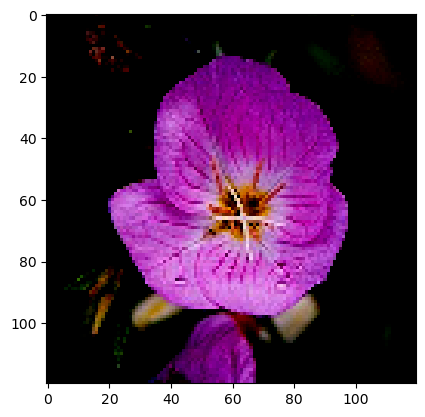

In [6]:
# sampling

for i,j in train.take(1):
    plt.imshow((i[0].numpy()))

In [7]:
def make_discriminator(img: tuple[int]) -> keras.Model:
    discriminator = tf.keras.Sequential(name='Discriminator')

    discriminator.add(InputLayer(shape=(img[0],img[1],3), name='Input'))

    discriminator.add(Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', name='convo_1'))
    discriminator.add(LeakyReLU(name='Leaky_1'))
    discriminator.add(Dropout(0.1,name='dropout_1'))

    discriminator.add(Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', name='convo_2'))
    discriminator.add(LeakyReLU(name='Leaky_2'))
    discriminator.add(Dropout(0.1,name='dropout_2'))

    discriminator.add(Conv2D(filters=256, kernel_size=(3,3), strides=2, padding='same', name='convo_3'))
    discriminator.add(LeakyReLU(name='Leaky_3'))
    discriminator.add(Dropout(0.1,name='dropout_3'))

    discriminator.add(Conv2D(filters=512, kernel_size=(3,3), strides=2, padding='same', name='convo_4'))
    discriminator.add(LeakyReLU(name='Leaky_4'))
    discriminator.add(Dropout(0.1,name='dropout_4'))

    discriminator.add(Conv2D(filters=512, kernel_size=(3,3), strides=2, padding='same', name='convo_5'))
    discriminator.add(LeakyReLU(name='Leaky_5'))
    discriminator.add(Dropout(0.1,name='dropout_5'))
    discriminator.add(Flatten(name='flat'))

    discriminator.add(Dense(256,name='dense_1',activation='relu'))
    discriminator.add(Dense(128,name='dense_2',activation='relu'))
    discriminator.add(Dense(64,name='dense_3',activation='relu'))
    discriminator.add(Dense(32,name='dense_4',activation='relu'))
    discriminator.add(Dense(16,name='dense_5',activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid', name='final'))

    return discriminator


In [8]:
make_discriminator(IMG_SIZE).summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convo_1 (Conv2D)                │ (None, 60, 60, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_1 (LeakyReLU)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convo_2 (Conv2D)                │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_2 (LeakyReLU)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convo_3 (Conv2D)                │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_3 (LeakyReLU)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convo_4 (Conv2D)                │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_4 (LeakyReLU)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convo_5 (Conv2D)                │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Leaky_5 (LeakyReLU)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,051,969 (23.09 MB)

 Trainable params: 6,051,969 (23.09 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
latent_dim = np.array([5,5,512])
noise_shape = 128

def make_generator(latent_dim:np.ndarray,noise_shape:int) -> keras.Model:
    generator = tf.keras.Sequential(name='generator')

    generator.add(InputLayer((noise_shape,),name='input'))
    generator.add(Dense(np.prod(latent_dim),name='dense'))
    generator.add(BatchNormalization(name='norm_1'))
    generator.add(LeakyReLU(name='leaky_1'))

    generator.add(Reshape(latent_dim,name='reshape'))
    generator.add(Conv2DTranspose(512,(3,3),strides=3,padding='same', name='conv_1'))
    generator.add(BatchNormalization(name='norm_2'))
    generator.add(LeakyReLU(name='leaky_2'))

    generator.add(Conv2DTranspose(256,(3,3),strides=1,padding='same', name='conv_2'))
    generator.add(BatchNormalization(name='norm_3'))
    generator.add(LeakyReLU(name='leaky_3'))

    generator.add(Conv2DTranspose(256,(3,3),strides=2,padding='same', name='conv_3'))
    generator.add(BatchNormalization(name='norm_4'))
    generator.add(LeakyReLU(name='leaky_4'))

    generator.add(Conv2DTranspose(128,(3,3),strides=1,padding='same', name='conv_4'))
    generator.add(BatchNormalization(name='norm_5'))
    generator.add(LeakyReLU(name='leaky_5'))

    generator.add(Conv2DTranspose(128,(3,3),strides=2,padding='same', name='conv_5'))
    generator.add(BatchNormalization(name='norm_6'))
    generator.add(LeakyReLU(name='leaky_6'))

    generator.add(Conv2DTranspose(64,(3,3),strides=1,padding='same', name='conv_6'))
    generator.add(BatchNormalization(name='norm_7'))
    generator.add(LeakyReLU(name='leaky_7'))

    generator.add(Conv2DTranspose(3,(3,3),strides=2,padding='same', name='final',activation='tanh'))

    
    return generator


In [10]:
make_generator(latent_dim,noise_shape).summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12800)          │     1,651,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1 (BatchNormalization)     │ (None, 12800)          │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_1 (LeakyReLU)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2DTranspose)        │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2 (BatchNormalization)     │ (None, 15, 15, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_2 (LeakyReLU)             │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2DTranspose)        │ (None, 15, 15, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_3 (BatchNormalization)     │ (None, 15, 15, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_3 (LeakyReLU)             │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2DTranspose)        │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_4 (BatchNormalization)     │ (None, 30, 30, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_4 (LeakyReLU)             │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2DTranspose)        │ (None, 30, 30, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_5 (BatchNormalization)     │ (None, 30, 30, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_5 (LeakyReLU)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2DTranspose)        │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_6 (BatchNormalization)     │ (None, 60, 60, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_6 (LeakyReLU)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2DTranspose)        │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_7 (BatchNormalization)     │ (None, 60, 60, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_7 (LeakyReLU)             │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final (Conv2DTranspose)         │ (None, 120, 120, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,355,715 (24.25 MB)

 Trainable params: 6,327,427 (24.14 MB)

 Non-trainable params: 28,288 (110.50 KB)

In [8]:
#generator = make_generator(latent_dim,noise_shape)
#discriminator = make_discriminator(IMG_SIZE)

In [9]:
"""@tf.function
def train_model(image):
    noise=  tf.random.normal([32, noise_shape])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise)
        
        real, fake = discriminator(image), discriminator(generated)
        gen_, dis_ = gen_loss(fake), dis_loss(real,fake)
        
    gradients_g = gen_tape.gradient(gen_, generator.trainable_variables)
    gradients_d = disc_tape.gradient(dis_, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_g, generator.trainable_variables))
    dis_opt.apply_gradients(zip(gradients_d, discriminator.trainable_variables))"""
    

'@tf.function\ndef train_model(image):\n    noise=  tf.random.normal([32, noise_shape])\n\n    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:\n        generated = generator(noise)\n        \n        real, fake = discriminator(image), discriminator(generated)\n        gen_, dis_ = gen_loss(fake), dis_loss(real,fake)\n        \n    gradients_g = gen_tape.gradient(gen_, generator.trainable_variables)\n    gradients_d = disc_tape.gradient(dis_, discriminator.trainable_variables)\n\n    gen_opt.apply_gradients(zip(gradients_g, generator.trainable_variables))\n    dis_opt.apply_gradients(zip(gradients_d, discriminator.trainable_variables))'

In [11]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


def dis_loss(real,fake):
    real_ = cross_entropy(tf.ones_like(real), real)
    fake_ = cross_entropy(tf.zeros_like(fake), fake)
    total = real_ + fake_
    return total

In [22]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator(self.latent_shape,self.noise_shape)
        self.discriminator = make_discriminator(self.img)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.dis_loss = tf.keras.metrics.Mean(name="discriminator_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.dis_loss]
    
    def compile(self,gen_opt,dis_opt):
        super(GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt

        
    def call(self,noise):
        gen_img = self.generator(noise,training=False)
        return gen_img
    
    @tf.function
    def train_step(self, image):
        noise=  tf.random.normal([32, self.noise_shape])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator(noise,training=True)
        
            real = self.discriminator(image,training=True)
            fake = self.discriminator(generated,training=True)
            gen_loss_ =  gen_loss(fake)
            dis_loss_ = dis_loss(real,fake)
        
        gradients_g = gen_tape.gradient(gen_loss_, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_loss_, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))

        self.gen_loss.update_state(gen_loss_)
        self.dis_loss.update_state(dis_loss_)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):
        try:
            self.generator.save('../saved_weights/gen.keras')
        except:
            print('Error saving the generator')
        
        try:
            self.discriminator.save('../saved_weights/dis.keras')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):
        try:
            self.generator.load_weights('../saved_weights/gen.keras')
        except:
            print('Error loading the generator')
        
        try:
            self.discriminator.load_weights('../saved_weights/dis.keras')
        except:
            print('Error loading the discriminator')
                

In [23]:
gan = GAN(latent_dim,noise_shape,IMG_SIZE)

gen_opt = Adam(learning_rate=0.0005)
dis_opt = Adam(learning_rate=0.00001)

In [24]:
gan.load_model()

In [25]:
gan.compile(gen_opt,dis_opt)

In [104]:
history=gan.fit(train,epochs=10)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - discriminator_loss: 1.3931 - generator_loss: 0.7288
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - discriminator_loss: 1.3236 - generator_loss: 0.8671
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - discriminator_loss: 1.2689 - generator_loss: 0.8407
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - discriminator_loss: 1.3231 - generator_loss: 0.7681
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - discriminator_loss: 1.3307 - generator_loss: 0.7731
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - discriminator_loss: 1.3940 - generator_loss: 0.8314
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - discriminator_loss: 1.3227 - generator_loss: 0.7756
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - discriminator_loss: 1.3314 - generator_loss: 0.8017
Epoch 9/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - discriminator_loss: 1.4121 - generator_loss: 0.8487
Epoch 10/10
205/205

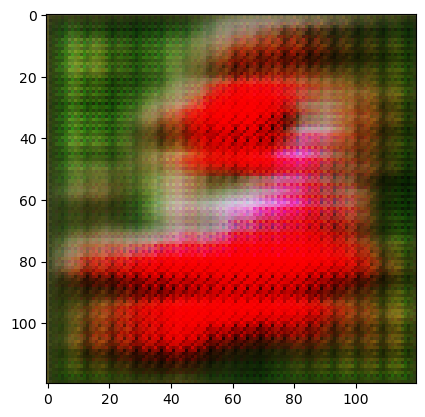

In [101]:
noise=  tf.random.normal([16, noise_shape],seed=5)

pred = gan(noise)
idx = randint(0,pred.shape[0]-1)
plt.imshow((pred[idx, :, :, :]+1)/2.0)


In [102]:
gan.save_model()

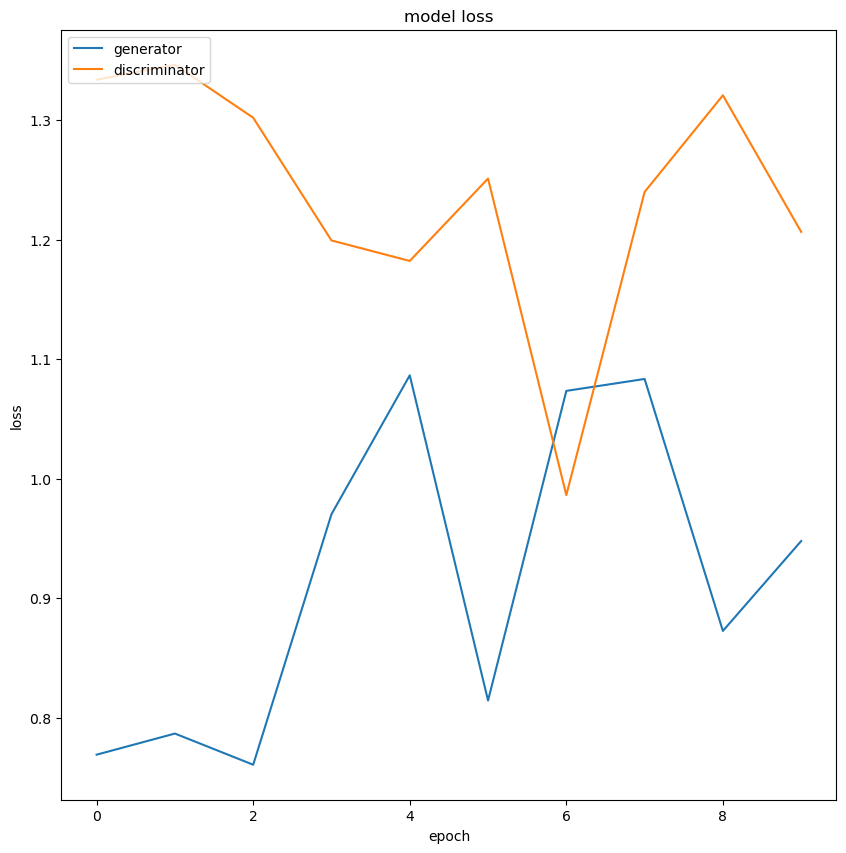

In [103]:
plt.figure(figsize=(10,10))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

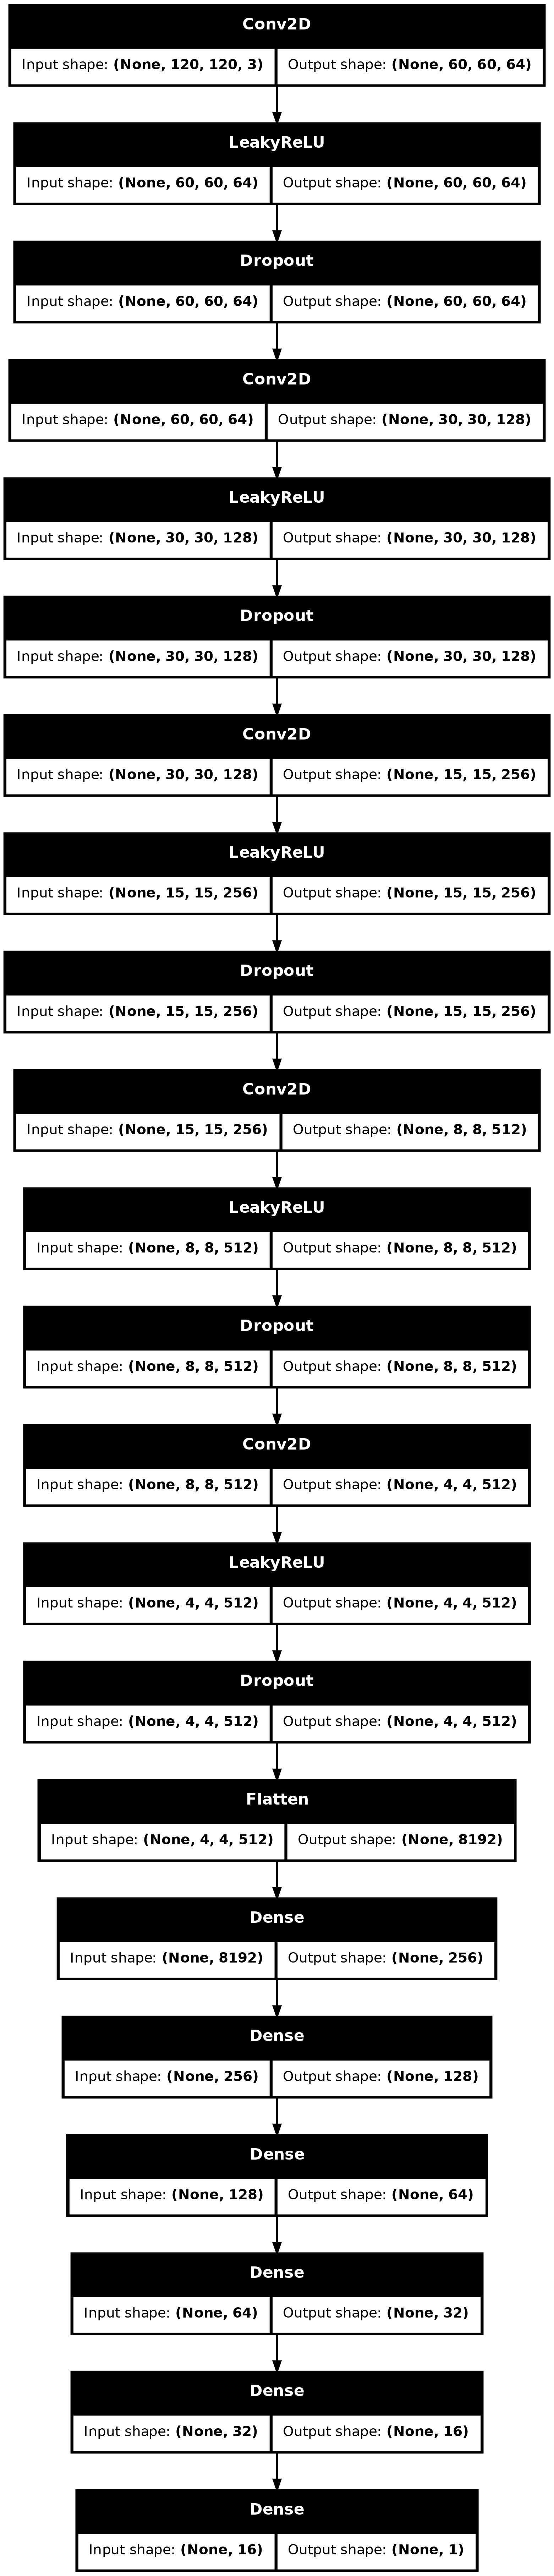

In [97]:
tf.keras.utils.plot_model(make_discriminator(IMG_SIZE), show_shapes=True, dpi=200)

In [17]:
gan_ = GAN_pre(latent_dim,noise_shape,IMG_SIZE,pre_trained_dis)

gen_opt_ = Adam(learning_rate=0.0005)
dis_opt_ = Adam(learning_rate=0.00001)

cross_entropy_ = BinaryCrossentropy(from_logits=True)

gen_loss_ = lambda x: cross_entropy_(tf.ones_like(x), x)
dis_loss_ = lambda x,y: cross_entropy_(tf.ones_like(x), x) + cross_entropy_(tf.zeros_like(y), y)

NameError: name 'GAN_pre' is not defined

In [ ]:
gan_.compile(gen_opt_,dis_opt_,gen_loss_,dis_loss_)

In [ ]:
gan_.fit(train,epochs=10)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - discriminator_loss: 39441.1328 - generator_loss: 2.7925e-32
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39439.8906 - generator_loss: 2.7984e-32
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39439.1875 - generator_loss: 2.8037e-32
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39440.6172 - generator_loss: 2.7946e-32
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39437.5742 - generator_loss: 2.8096e-32
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39440.1250 - generator_loss: 2.7970e-32
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39441.8164 - generator_loss: 2.7882e-32
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_loss: 39439.1328 - generator_loss: 2.8025e-32
Epoch 9/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - discriminator_lo

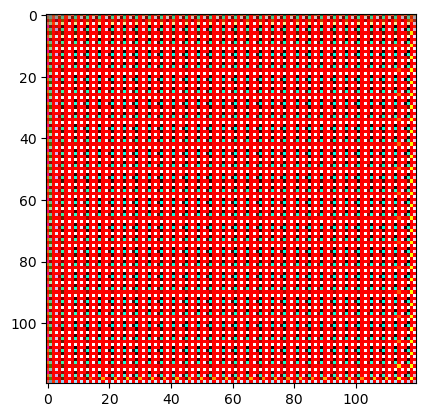

In [ ]:
noise=  tf.random.normal([32, noise_shape])

pred = gan_(noise)
plt.imshow((pred[0, :, :, :]))